## General information

```
Many diseases, including cancer, are believed to have a contributing factor in common. Ion channels are pore-forming proteins present in animals and plants. They encode learning and memory, help fight infections, enable pain signals, and stimulate muscle contraction. If scientists could better study ion channels, which may be possible with the aid of machine learning, it could have a far-reaching impact.

When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research. Scientists hope that technology could enable rapid automatic detection of ion channel current events in raw data.
```

In other words this competition we work with time series and predict classes for each time point. In the original [paper](https://www.nature.com/articles/s42003-019-0729-3) deep learning approach is recommended. For now I'll build an LGBM model.

A notice: the competition has QWK metric, this means we can work with it as with classification or regression problem.

By the way, at last we have a normal competition and not kernel-only!

![](https://storage.googleapis.com/kaggle-media/competitions/Liverpool/ion%20image.jpg)

*Work in progress. Really :)*

## Import libraries

In [6]:
import numpy as np
import pandas as pd
import os
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, f1_score
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
# import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed

In [7]:
# PATH = '/kaggle/input/'
PATH = '/Users/helen/Desktop/Data/'

## helper functions and classes

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 10
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 0.5] = 0
    y_pred[np.where(np.logical_and(y_pred > 0.5, y_pred <= 1.5))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.5, y_pred <= 2.5))] = 2
    y_pred[np.where(np.logical_and(y_pred > 2.5, y_pred <= 3.5))] = 3
    y_pred[np.where(np.logical_and(y_pred > 3.5, y_pred <= 4.5))] = 4
    y_pred[np.where(np.logical_and(y_pred > 4.5, y_pred <= 5.5))] = 5
    y_pred[np.where(np.logical_and(y_pred > 5.5, y_pred <= 6.5))] = 6
    y_pred[np.where(np.logical_and(y_pred > 6.5, y_pred <= 7.5))] = 7
    y_pred[np.where(np.logical_and(y_pred > 7.5, y_pred <= 8.5))] = 8
    y_pred[np.where(np.logical_and(y_pred > 8.5, y_pred <= 9.5))] = 9
    y_pred[y_pred > 9.5] = 10

    return 'cappa', qwk(y_true, y_pred), True


class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['eval_metric'] == 'cappa':
            eval_metric = eval_qwk_lgb_regr
        elif params['eval_metric'] == 'f1_macro':
            eval_metric = evaluate_macroF1_lgb
        else:
            eval_metric = params['eval_metric']

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)

def evaluate_macroF1_lgb(truth, predictions):
    
    # pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, predictions.astype(int), average='macro')
    return ('f1_macro', f1, True) 


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=evaluate_macroF1_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)

In [10]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):



        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)


        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [11]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['batch'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [12]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 11# 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), 11))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, self.oof.argmax(1)), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof.argmax(1))
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
            X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [13]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [14]:
class OptimizedRounderF1(object):
    """
    An optimizer for rounding thresholds
    to maximize f1 score
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -metrics.f1_score(y, X_p, average='macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

## Data loading and overview

In [15]:

file_path = PATH + 'liverpool-ion-switching'
train = pd.read_csv(f'{file_path}/train.csv')
submission = pd.read_csv(f'{file_path}/sample_submission.csv')
test = pd.read_csv(f'{file_path}/test.csv')

In [16]:
train.shape, test.shape

((5000000, 3), (2000000, 2))

In [17]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [18]:
test.head()

,time,signal
0,500.000099999999975,-2.6498
1,500.000200000000007,-2.8494
2,500.000299999999982,-2.8600
3,500.000400000000013,-2.4350
4,500.000499999999988,-2.6155


As we can see, we have two columns with data available: timestamp and signal value. Our task is to predict open_channels.

Notice, that while time in train data starts from `0.0001`, time in test data starts from `500.0001`. Let's start by fixing it.

In [19]:
test['time'] = (test['time'] - 500).round(4)

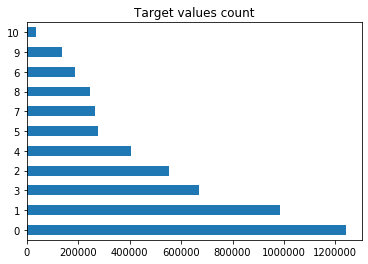

In [20]:
train['open_channels'].value_counts().plot(kind='barh');
plt.title('Target values count');

As per data description:

```
IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch).
In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001.
```
I think it would be reasonable to create a new column showing the batch number and use groupkfold cross-validation based on the batch

In [21]:
train['batch'] = 0
for i in range(0, 10):
    train.iloc[i * 500000: 500000 * (i + 1), 3] = i

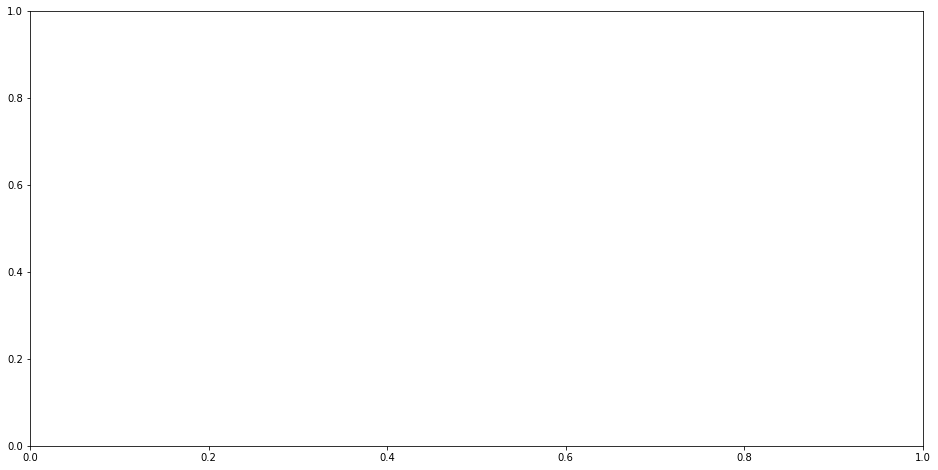

In [22]:
fig, ax1 = plt.subplots(figsize=(16, 8));

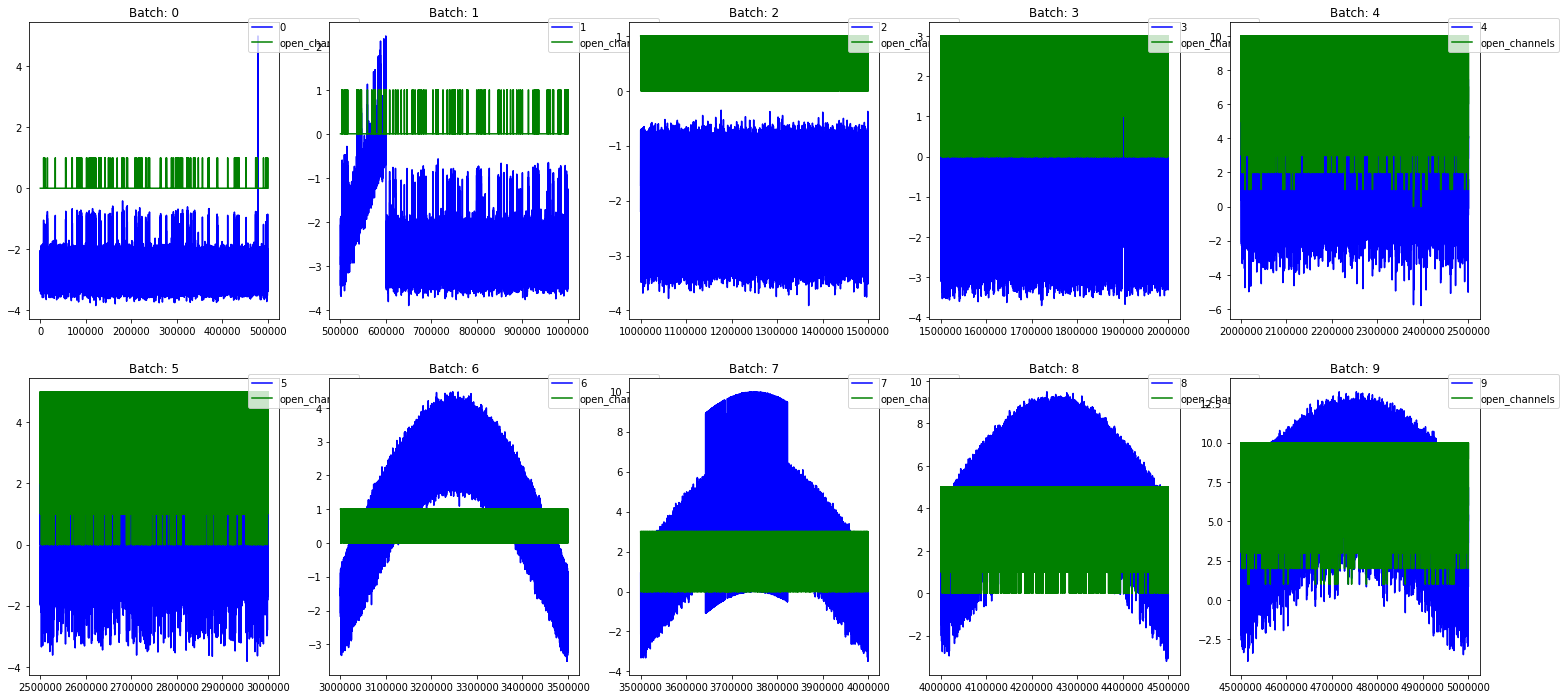

In [23]:
plt.figure(figsize=(26, 12))
for i, b in enumerate(train['batch'].unique()):
    plt.subplot(2, 5, i + 1)
    plt.plot(train.loc[train['batch'] == b, ['signal']], color='blue')
    plt.title(f'Batch: {b}')
    ax1.set_ylabel(b, color='b')
    # plt.legend([col])
    ax2 = ax1.twinx()
    plt.plot(train.loc[train['batch'] == b, ['open_channels']], color='g')
    ax2.set_ylabel('Open channels', color='g')
    plt.legend([b, 'open_channels'], loc=(0.875, 0.9))
    plt.grid(False)

As we can see different batches have very different distributions of target variable.

Hm. I think I'll need to make better plots in the next version 

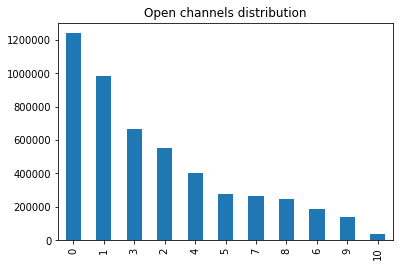

In [24]:
train['open_channels'].value_counts().plot(kind='bar')
plt.title('Open channels distribution');

## Feature Engineering


The idea of feature generation is taken from these kernels: https://www.kaggle.com/gpreda/ion-switching-advanced-eda-and-prediction
I also add some more features

In [25]:
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    train['batch'] = ((train['time'] * 10_000) - 1) // batch_size
    train['batch_index'] = ((train['time'] * 10_000) - 1)  - (train['batch'] * batch_size)
    train['batch_slices'] = train['batch_index']  // (batch_size / 10)
    train['batch_slices2'] = train['batch'].astype(str).str.zfill(3) + '_' + train['batch_slices'].astype(str).str.zfill(3)
    
    for agg_feature in ['batch', 'batch_slices2']:
        train[f"min_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('min')
        train[f"max_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('max')
        train[f"std_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('std')
        train[f"mean_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('mean')
        
        train[f"min_{agg_feature}_{batch_size}_diff"] = train[f"min_{agg_feature}_{batch_size}"] - train['signal']
        train[f"max_{agg_feature}_{batch_size}_diff"] = train[f"max_{agg_feature}_{batch_size}"] - train['signal']
        train[f"std_{agg_feature}_{batch_size}_diff"] = train[f"std_{agg_feature}_{batch_size}"] - train['signal']
        train[f"mean_{agg_feature}_{batch_size}_diff"] = train[f"mean_{agg_feature}_{batch_size}"] - train['signal']
        
        train[f'signal_shift+1_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(1)['signal']
        train[f'signal_shift-1_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(-1)['signal']
        train[f'signal_shift+2_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(2)['signal']
        train[f'signal_shift-2_{agg_feature}_{batch_size}'] = train.groupby([agg_feature]).shift(-2)['signal']

    window_sizes = [1000, 5000, 10000, 25000]
    for window in window_sizes:
        train["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']

        ewma = pd.Series.ewm

        train[f'exp_Moving__{window}_{batch_size}'] = train.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())
train.fillna(0, inplace=True)

In [26]:
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    test['batch'] = ((test['time'] * 10_000) - 1) // batch_size
    test['batch_index'] = ((test['time'] * 10_000) - 1)  - (test['batch'] * batch_size)
    test['batch_slices'] = test['batch_index']  // (batch_size / 10)
    test['batch_slices2'] = test['batch'].astype(str).str.zfill(3) + '_' + test['batch_slices'].astype(str).str.zfill(3)
    
    for agg_feature in ['batch', 'batch_slices2']:
        test[f"min_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('min')
        test[f"max_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('max')
        test[f"std_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('std')
        test[f"mean_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('mean')
        
        test[f"min_{agg_feature}_{batch_size}_diff"] = test[f"min_{agg_feature}_{batch_size}"] - test['signal']
        test[f"max_{agg_feature}_{batch_size}_diff"] = test[f"max_{agg_feature}_{batch_size}"] - test['signal']
        test[f"std_{agg_feature}_{batch_size}_diff"] = test[f"std_{agg_feature}_{batch_size}"] - test['signal']
        test[f"mean_{agg_feature}_{batch_size}_diff"] = test[f"mean_{agg_feature}_{batch_size}"] - test['signal']
        
        test[f'signal_shift+1_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(1)['signal']
        test[f'signal_shift-1_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(-1)['signal']
        test[f'signal_shift+2_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(2)['signal']
        test[f'signal_shift-2_{agg_feature}_{batch_size}'] = test.groupby([agg_feature]).shift(-2)['signal']

    window_sizes = [1000, 5000, 10000, 25000]
    for window in window_sizes:
        test["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']

        ewma = pd.Series.ewm

        test[f'exp_Moving__{window}_{batch_size}'] = test.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())
test.fillna(0, inplace=True)

In [27]:
train.head()

,time,signal,open_channels,batch,batch_index,batch_slices,batch_slices2,min_batch_10000,max_batch_10000,std_batch_10000,...,signal_shift+2_batch_slices2_50000,signal_shift-2_batch_slices2_50000,rolling_std_1000_batch_50000,exp_Moving__1000_50000,rolling_std_5000_batch_50000,exp_Moving__5000_50000,rolling_std_10000_batch_50000,exp_Moving__10000_50000,rolling_std_25000_batch_50000,exp_Moving__25000_50000
0,0.0001,-2.7600,0,0.0,0.0,0.0,0.0_0.0,-3.5896,-1.0483,0.243935804306588,...,0.0000,-2.4074,0.0,-2.76000000,0.0,-2.76000000,0.0,-2.76000000,0.0,-2.76000000
1,0.0002,-2.8557,0,0.0,1.0,0.0,0.0_0.0,-3.5896,-1.0483,0.243935804306588,...,0.0000,-3.1404,0.0,-2.80785000,0.0,-2.80785000,0.0,-2.80785000,0.0,-2.80785000
2,0.0003,-2.4074,0,0.0,2.0,0.0,0.0_0.0,-3.5896,-1.0483,0.243935804306588,...,-2.7600,-3.1525,0.0,-2.60762500,0.0,-2.60762500,0.0,-2.60762500,0.0,-2.60762500
3,0.0004,-3.1404,0,0.0,3.0,0.0,0.0_0.0,-3.5896,-1.0483,0.243935804306588,...,-2.8557,-2.6418,0.0,-2.87401250,0.0,-2.87401250,0.0,-2.87401250,0.0,-2.87401250
4,0.0005,-3.1525,0,0.0,4.0,0.0,0.0_0.0,-3.5896,-1.0483,0.243935804306588,...,-2.4074,-2.6993,0.0,-3.01325625,0.0,-3.01325625,0.0,-3.01325625,0.0,-3.01325625


## Modelling

It is modelling time! I'll use my usual class for modelling with lgbm.

Please, notice that I calculate cappa metric, but it isn't optimized and uses default thresholds, so the metric values are funny. I think I'll set better thresholds later.
It would be a very bad idea to optimize thresholds for each iteration, as it would take too much time and could cause overfitting.

In [28]:
n_fold = 5
# folds = KFold(n_splits=n_fold, shuffle=True)
# folds = StratifiedKFold(n_splits=n_fold)
folds = GroupKFold(n_splits=n_fold)

In [29]:
params = {'n_estimators': 2000,
          'num_leaves': 128,
          'min_data_in_leaf': 60,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.05,
          "boosting": "gbdt",
          "metric": 'rmse',
          "verbosity": -1,
          'verbose': 100,
          'early_stopping_rounds': 50,
          'eval_metric': 'rmse',
          'num_threads': -1
            }

In [30]:
y = train['open_channels']

In [31]:
train = reduce_mem_usage(train)

Mem. usage decreased to 1006.13 Mb (74.4% reduction)


In [32]:
list(train.columns)

['time',
 'signal',
 'open_channels',
 'batch',
 'batch_index',
 'batch_slices',
 'batch_slices2',
 'min_batch_10000',
 'max_batch_10000',
 'std_batch_10000',
 'mean_batch_10000',
 'min_batch_10000_diff',
 'max_batch_10000_diff',
 'std_batch_10000_diff',
 'mean_batch_10000_diff',
 'signal_shift+1_batch_10000',
 'signal_shift-1_batch_10000',
 'signal_shift+2_batch_10000',
 'signal_shift-2_batch_10000',
 'min_batch_slices2_10000',
 'max_batch_slices2_10000',
 'std_batch_slices2_10000',
 'mean_batch_slices2_10000',
 'min_batch_slices2_10000_diff',
 'max_batch_slices2_10000_diff',
 'std_batch_slices2_10000_diff',
 'mean_batch_slices2_10000_diff',
 'signal_shift+1_batch_slices2_10000',
 'signal_shift-1_batch_slices2_10000',
 'signal_shift+2_batch_slices2_10000',
 'signal_shift-2_batch_slices2_10000',
 'rolling_std_1000_batch_10000',
 'exp_Moving__1000_10000',
 'rolling_std_5000_batch_10000',
 'exp_Moving__5000_10000',
 'rolling_std_10000_batch_10000',
 'exp_Moving__10000_10000',
 'rolling_std_25000_batch_10000',
 'exp_Moving__25000_10000',
 'min_batch_25000',
 'max_batch_25000',
 'std_batch_25000',
 'mean_batch_25000',
 'min_batch_25000_diff',
 'max_batch_25000_diff',
 'std_batch_25000_diff',
 'mean_batch_25000_diff',
 'signal_shift+1_batch_25000',
 'signal_shift-1_batch_25000',
 'signal_shift+2_batch_25000',
 'signal_shift-2_batch_25000',
 'min_batch_slices2_25000',
 'max_batch_slices2_25000',
 'std_batch_slices2_25000',
 'mean_batch_slices2_25000',
 'min_batch_slices2_25000_diff',
 'max_batch_slices2_25000_diff',
 'std_batch_slices2_25000_diff',
 'mean_batch_slices2_25000_diff',
 'signal_shift+1_batch_slices2_25000',
 'signal_shift-1_batch_slices2_25000',
 'signal_shift+2_batch_slices2_25000',
 'signal_shift-2_batch_slices2_25000',
 'rolling_std_1000_batch_25000',
 'exp_Moving__1000_25000',
 'rolling_std_5000_batch_25000',
 'exp_Moving__5000_25000',
 'rolling_std_10000_batch_25000',
 'exp_Moving__10000_25000',
 'rolling_std_25000_batch_25000',
 'exp_Moving__25000_25000',
 'min_batch_50000',
 'max_batch_50000',
 'std_batch_50000',
 'mean_batch_50000',
 'min_batch_50000_diff',
 'max_batch_50000_diff',
 'std_batch_50000_diff',
 'mean_batch_50000_diff',
 'signal_shift+1_batch_50000',
 'signal_shift-1_batch_50000',
 'signal_shift+2_batch_50000',
 'signal_shift-2_batch_50000',
 'min_batch_slices2_50000',
 'max_batch_slices2_50000',
 'std_batch_slices2_50000',
 'mean_batch_slices2_50000',
 'min_batch_slices2_50000_diff',
 'max_batch_slices2_50000_diff',
 'std_batch_slices2_50000_diff',
 'mean_batch_slices2_50000_diff',
 'signal_shift+1_batch_slices2_50000',
 'signal_shift-1_batch_slices2_50000',
 'signal_shift+2_batch_slices2_50000',
 'signal_shift-2_batch_slices2_50000',
 'rolling_std_1000_batch_50000',
 'exp_Moving__1000_50000',
 'rolling_std_5000_batch_50000',
 'exp_Moving__5000_50000',
 'rolling_std_10000_batch_50000',
 'exp_Moving__10000_50000',
 'rolling_std_25000_batch_50000',
 'exp_Moving__25000_50000']

Fold 1 started at Tue Mar 24 18:26:37 2020
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.456416	valid's rmse: 0.473622
[200]	train's rmse: 0.162414	valid's rmse: 0.176987
[300]	train's rmse: 0.159329	valid's rmse: 0.175193
[400]	train's rmse: 0.157668	valid's rmse: 0.174795
[500]	train's rmse: 0.156452	valid's rmse: 0.174558
[600]	train's rmse: 0.155308	valid's rmse: 0.174362
[700]	train's rmse: 0.154348	valid's rmse: 0.174263
[800]	train's rmse: 0.153472	valid's rmse: 0.174169
[900]	train's rmse: 0.152588	valid's rmse: 0.174083
[1000]	train's rmse: 0.151751	valid's rmse: 0.173976
[1100]	train's rmse: 0.150993	valid's rmse: 0.173914
[1200]	train's rmse: 0.150263	valid's rmse: 0.173883
[1300]	train's rmse: 0.149493	valid's rmse: 0.173805
[1400]	train's rmse: 0.148786	valid's rmse: 0.173733
[1500]	train's rmse: 0.1481	valid's rmse: 0.173693
[1600]	train's rmse: 0.147429	valid's rmse: 0.173624
Early stopping, best iteration is:
[1624]	train's rmse: 0.1

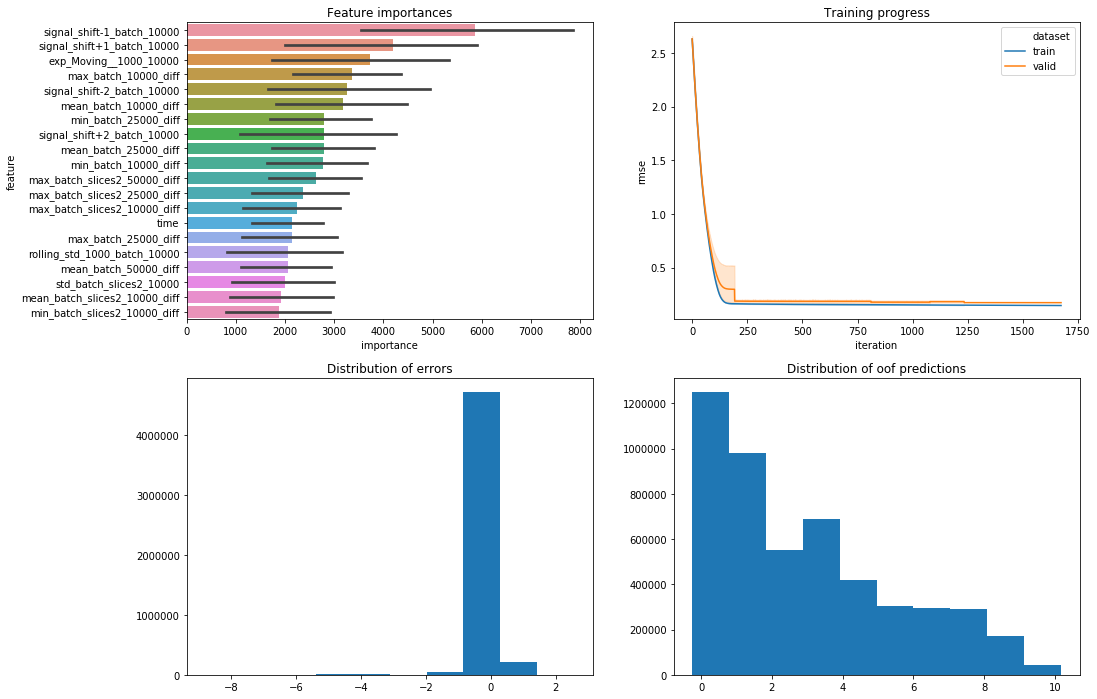

In [33]:
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model.fit(X=train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='rmse', cols_to_drop=['batch', 'open_channels', 'batch_index', 'batch_slices', 'batch_slices2'])

Fold 1 started at Tue Mar 24 18:58:43 2020
Training until validation scores don't improve for 20 rounds
[100]	train's l1: 0.305823	valid's l1: 0.346085
[200]	train's l1: 0.0856012	valid's l1: 0.0965265
[300]	train's l1: 0.0555129	valid's l1: 0.062719
[400]	train's l1: 0.0515286	valid's l1: 0.0581613
[500]	train's l1: 0.050992	valid's l1: 0.0575577
[600]	train's l1: 0.0508813	valid's l1: 0.0574663
[700]	train's l1: 0.0508478	valid's l1: 0.0574532
[800]	train's l1: 0.0508189	valid's l1: 0.0574215
[900]	train's l1: 0.0508052	valid's l1: 0.0574124
Early stopping, best iteration is:
[899]	train's l1: 0.0508061	valid's l1: 0.0574109
Fold 2 started at Tue Mar 24 19:12:53 2020
Training until validation scores don't improve for 20 rounds
[100]	train's l1: 0.327009	valid's l1: 0.333475
[200]	train's l1: 0.0907852	valid's l1: 0.0970056
[300]	train's l1: 0.0595744	valid's l1: 0.0660289
[400]	train's l1: 0.0551032	valid's l1: 0.0617764
[500]	train's l1: 0.0543443	valid's l1: 0.0612363
[600]	train's

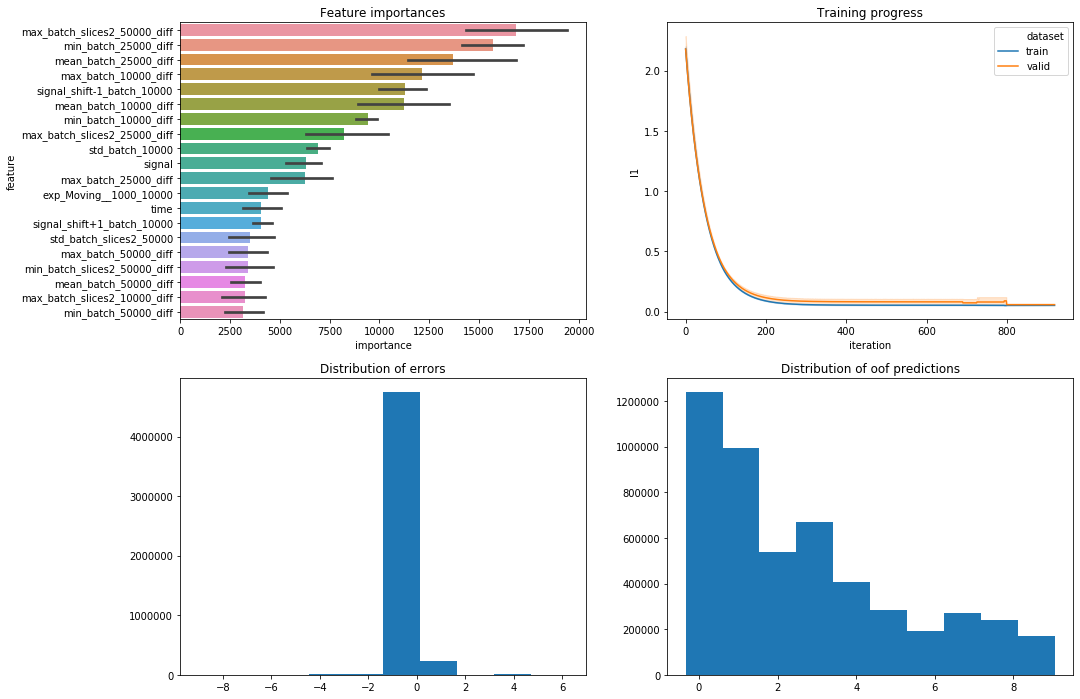

In [34]:
params1 = {'n_estimators': 2000,
          'num_leaves': 256,
          'min_data_in_leaf': 32,
          'objective': 'mape',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "metric": 'mae',
          "verbosity": -1,
          'verbose': 100,
          'early_stopping_rounds': 20,
          'eval_metric': 'mae',
          'num_threads': -1
            }
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=train, y=y, folds=folds, params=params1, preprocesser=mt, transformers=transformers,
                    eval_metric='l1', cols_to_drop=['batch', 'open_channels', 'batch_index', 'batch_slices', 'batch_slices2'])

## Optimizing predictions.

Note that this is a baseline optimization. I'm not sure that finding thresholds based on the whole train is optimal.

In [35]:
%%time
pr = (regressor_model.predict(train) + regressor_model1.predict(train)) / 2

# optR = OptimizedRounder()
# optR.fit(pr.reshape(-1,), y)
# coefficients = optR.coefficients()
# print(coefficients)

CPU times: user 1h 14min 51s, sys: 1min 20s, total: 1h 16min 11s
Wall time: 11min 50s


In [36]:
del train
gc.collect()

16200

In [37]:
optRf = OptimizedRounderF1()
optRf.fit(pr.reshape(-1,), y)
coefficientsf = optRf.coefficients()
print(coefficientsf)

[0.52572295 1.52757378 2.67755496 3.73319998 4.2608136  5.23367775
 6.32440529 7.30558138 8.22347479 9.18218498]


In [38]:
# opt_preds = optR.predict(pr.reshape(-1, ), coefficients)
# print('qwk', qwk(y, opt_preds))
# print('f1', metrics.f1_score(y, opt_preds, average = 'macro'))

In [39]:
opt_predsf = optRf.predict(pr.reshape(-1, ), coefficientsf)
print('qwk', qwk(y, opt_predsf))
print('f1', metrics.f1_score(y, opt_predsf, average = 'macro'))

qwk 0.9971957688950666
f1 0.9294876954187538


In [40]:
test_preds = (regressor_model.predict(test) + regressor_model1.predict(test)) / 2
# opt_test_preds = optR.predict(test_preds.reshape(-1, ), coefficients)
opt_test_predsf = optRf.predict(test_preds.reshape(-1, ), coefficientsf)

Text(0.5, 1.0, 'Predictions distribution')

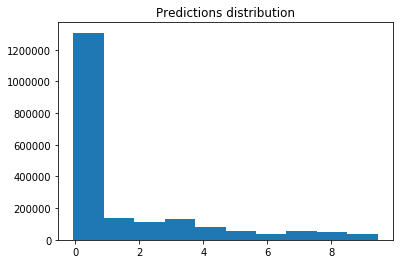

In [41]:
plt.hist(test_preds);
plt.title('Predictions distribution')

In [42]:
# submission['open_channels'] = opt_test_preds
# submission.to_csv('submission_lgb_optimized.csv', index=False, float_format='%.4f')

In [43]:
submission['open_channels'] = opt_test_predsf
submission.to_csv('submission_blend_optimizedf.csv', index=False, float_format='%.4f')

In [44]:
submission['open_channels'] = test_preds.astype(int)
submission.to_csv('submission_blend.csv', index=False, float_format='%.4f')